In [1]:
from scipy.integrate import quad
from numpy import *
from matplotlib.pylab import *
import matplotlib as mpl
%matplotlib inline
#from pandas.core import *
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

from sklearn.decomposition import PCA,FastICA

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import pickle


In [3]:
#Jupyters: Proper Spine Model - Inhibition.ipynb
with open("../SpineModel/dis_baseline.pickle","rb") as f:
    vavgDiS,mesDiS,vtracsDiS,vtracsDDiS,vtracsSDiS,CtracsDiS,_,_ = pickle.load(f)

with open("../SpineModel/dis_baselineB_sps.pickle","rb") as f:
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3 = pickle.load(f)

with open("../SpineModel/All_baseline_dataset.pickle","rb") as f:
    vavgT,mesT,vtracsT,vtracsDT,vtracsST,CtracsT,me2T,_,dataT = pickle.load(f)


In [4]:
dataT.keys(),vtracsST.shape

(dict_keys(['#Bch', 'Dsb', 'Dss', 'd_interSp', 'Vtot', 'Vh', 'Ln', 'SA', 'nPSD', 'A1', 'A2', 'GPHN SNR', 'DiS-EMchk', 'Lneck', 'maxDneck', 'minDneck', 'meanDneck', 'Rneck', 'Lhead', 'maxDhead', 'minDhead', 'meanDhead', 'Ah', 'Rhead', 'L', 'D', 'AhA0']),
 (10002, 365))

In [5]:
pddataT = pd.DataFrame(dataT)

In [6]:
labels = ('Vh','A1','Ah','Dss','Rneck','Lhead','meanDhead')
datt = column_stack((dataT['Vh'],dataT['A1'],dataT['Ah'],dataT['Dss'],dataT['Rneck'],dataT['Lhead'],dataT['meanDhead']))

labels = ('A1','Dss','Rneck','SA')
datt = column_stack((dataT['A1'],dataT['Dss'],dataT['Rneck'],dataT['SA']))

In [7]:
pddataT = pd.DataFrame(data=datt,columns=labels)

In [8]:
regressor = LinearRegression()  
regressor.fit(datt, mesT[:,3])
coeforig = regressor.coef_*1.0
print(regressor.coef_)

[ 6.14864491e+00 -7.16923712e-03 -6.14108574e-04 -1.78065696e-02]


In [9]:
y_pred = regressor.predict(datt)

In [10]:
fullvarlinear = ((mesT[:,3]-y_pred)).var()
print(fullvarlinear)

0.0377532190369572


In [11]:
for i in range(datt.shape[1]):
    dattb = datt[:,1:]
    if i>0 and i<datt.shape[1]-2:
        dattb = column_stack((datt[:,:i],datt[:,(i+1):]))
    else:
        dattb = datt[:,:-1]
    regressor.fit(datt[:,i:(i+1)], mesT[:,3])
    y_pred0 = regressor.predict(datt[:,i:(i+1)])
    var0 = ((mesT[:,3]-y_pred0)).var()
    print(labels[i],var0,var(mesT[:,3]))

A1 0.08687696329228532 0.8410874220853587
Dss 0.7995186208289172 0.8410874220853587
Rneck 0.7504254063715273 0.8410874220853587
SA 0.8410218746626035 0.8410874220853587


In [12]:
idcs = arange(datt.shape[1]).tolist()
vardat = zeros((datt.shape[1],2))
y_predt = mesT[:,3]*0.0

for k in range(datt.shape[1]-1):
    var0 = var(mesT[:,3])
    minvar = var0
    varts = zeros(len(idcs))
    for iv,i in enumerate(idcs):
        regressor.fit(datt[:,i:(i+1)], mesT[:,3]-y_predt)
        y_pred = regressor.predict(datt[:,i:(i+1)])
        vart = ((mesT[:,3]-y_predt-y_pred)).var()
        varts[iv] = vart
    sel = argmin(varts)
    i = idcs[sel]
    regressor.fit(datt[:,i:(i+1)], mesT[:,3]-y_predt)
    y_pred = regressor.predict(datt[:,i:(i+1)])
    y_predt += y_pred
    
    vardat[k,:] = (idcs[sel],varts[sel])
    idcs.pop(sel)
    
i = idcs[0]
regressor.fit(datt[:,i:(i+1)], mesT[:,3]-y_predt)
y_pred = regressor.predict(datt[:,i:(i+1)])
vart = ((mesT[:,3]-y_predt-y_pred)).var()
vardat[-1,:] = (idcs[0],vart)

print(vardat)


[[0.         0.08687696]
 [1.         0.03997334]
 [2.         0.03802498]
 [3.         0.03787276]]


In [12]:
vsa = 1-(vardat[0,1])/var0
print(labels[int(vardat[0,0])],vsa*100)
for i in range(1,vardat.shape[0]):
    vs = 1-(vardat[i,1])/var0
    print(labels[int(vardat[i,0])],(vs-vsa)*100)
    vsa = vs

A1 89.09140323841807
Dss 3.401926100992614
Rneck 0.9671507174080163
SA 0.013374205940963613


Rneck 31.431502198647554 0.31431502198647554
A1 27.556664109443616 0.5898816630809117
Dss 1.0356709813699072 0.6002383728946108
SA 0.018645587598109525 0.6004248287705919


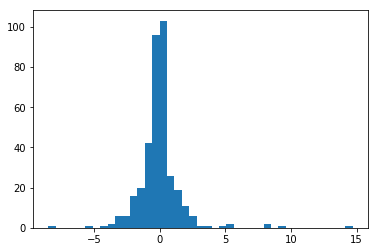

In [13]:
idcs = arange(datt.shape[1]).tolist()
vardat = zeros((datt.shape[1],2))
yrt = mesT[:,1]-mesT[:,2]
y_predt = yrt*0.0
var0 = var(yrt)
minvar = var0
for k in range(datt.shape[1]-1):
    varts = zeros(len(idcs))
    for iv,i in enumerate(idcs):
        regressor.fit(datt[:,i:(i+1)], yrt-y_predt)
        y_pred = regressor.predict(datt[:,i:(i+1)])
        vart = ((yrt-y_predt-y_pred)).var()
        varts[iv] = vart
    sel = argmin(varts)
    i = idcs[sel]
    regressor.fit(datt[:,i:(i+1)], yrt-y_predt)
    y_pred = regressor.predict(datt[:,i:(i+1)])
    y_predt += y_pred
    
    vardat[k,:] = (idcs[sel],varts[sel])
    idcs.pop(sel)
    
i = idcs[0]
regressor.fit(datt[:,i:(i+1)], yrt-y_predt)
y_pred = regressor.predict(datt[:,i:(i+1)])
vart = ((yrt-y_predt-y_pred)).var()
vardat[-1,:] = (idcs[0],vart)

hist(yrt-y_predt-y_pred,41)

#print(vardat)
vsa = 1-(vardat[0,1])/var0
print(labels[int(vardat[0,0])],vsa*100,vsa)
for i in range(1,vardat.shape[0]):
    vs = 1-(vardat[i,1])/var0
    print(labels[int(vardat[i,0])],(vs-vsa)*100,vs)
    vsa = vs

In [14]:
idct = 1.0*arange(5)
idct = delete(idct,2)
print(idct)

[0. 1. 3. 4.]


Rneck 31.431502198647554
A1 29.510694720546265
Dss 1.5978025580224042
SA 0.033601548853468


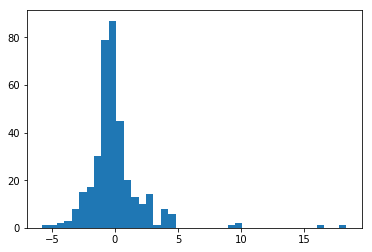

In [15]:
#Backwards!
idcs = arange(datt.shape[1]).tolist()
vardat = zeros((datt.shape[1],2))
yrt = mesT[:,1]-mesT[:,2]
y_predt = yrt*0.0
var0 = var(yrt)
minvar = var0
for k in range(datt.shape[1]-1):
    varts = zeros(len(idcs))
    #print(idcs)
    for iv,i in enumerate(idcs):
        idct = 1*array(idcs)
        idct = delete(idct,iv)
        dattb = datt[:,array(idct)]
        regressor.fit(dattb, yrt)
        y_pred = regressor.predict(dattb)
        vart = ((yrt-y_pred)).var()
        varts[iv] = vart
    #print(varts)
    sel = argmin(varts)
    i = idcs[sel]
    vardat[k,:] = (idcs[sel],varts[sel])
    idcs.pop(sel)
    
#print(i)
i = idcs[0]
regressor.fit(datt[:,i:(i+1)], yrt)
y_pred = regressor.predict(datt[:,i:(i+1)])
vart = ((yrt-y_pred)).var()
vardat[-1,:] = (idcs[0],var(yrt))
#print(vardat,var0)
hist(yrt-y_pred,41)

#print(vardat)
for i in range(vardat.shape[0]-1,0,-1):
    vsa = (vardat[i,1])/var0
    vs = (vardat[i-1,1])/var0
    print(labels[int(vardat[i,0])],(vsa-vs)*100)
    
regressor.fit(datt, yrt)
y_pred = regressor.predict(datt)
vart = ((yrt-y_pred)).var()
vsa = (vardat[0,1])/var0
vs = (vart)/var0
print(labels[int(vardat[0,0])],(vsa-vs)*100)


In [16]:
pddataT.shape

(365, 4)

In [17]:
def LinReg_varexplain_B(X,y,labels= None):
    if labels is None:
        try: 
            labels = X.keys()
        except:
            labels = arange(X.shape[1])
            
    idcs = arange(X.shape[1]).tolist()
    vardat = zeros((X.shape[1],2))
    
    var0 = var(y)
    #y_predt = y*0.0    
    for k in range(X.shape[1]-1):

        varts = zeros(len(idcs))
        #print(idcs)
        for iv,i in enumerate(idcs):
            
            idct = 1*array(idcs)
            idct = delete(idct,iv)
            Xb = X.values[:,array(idct)]
            
            regressor.fit(Xb, y)
            y_pred = regressor.predict(Xb)
            vart = ((y-y_pred)).var()
            
            varts[iv] = vart
        
        #print(varts)
        # We select column that affected the minimum and remove it
        sel = argmin(varts)
        i = idcs[sel]
        vardat[k,:] = (idcs[sel],varts[sel])
        idcs.pop(sel)

    #i = idcs[0]
    vardat[-1,:] = (idcs[0],var(y))
    #print(vardat,var0)
    #hist(y-y_pred,41)

    result = {}
    #print(vardat)
    for i in range(vardat.shape[0]-1,0,-1):
        vsa = (vardat[i,1])/var0
        vs = (vardat[i-1,1])/var0
        #print(labels[int(vardat[i,0])],(vsa-vs)*100)
        result[labels[int(vardat[i,0])]] = vsa-vs
        
    regressor.fit(X, y)
    y_pred = regressor.predict(X)
    vart = ((y-y_pred)).var()
    vsa = (vardat[0,1])/var0
    vs = (vart)/var0
    
    #print(labels[int(vardat[0,0])],(vsa-vs)*100)
    result[labels[int(vardat[0,0])]] = vsa-vs
    result['variance'] = var0
    return(result)

In [18]:
def LinReg_varexplain_F(X,y,labels= None):
    if labels is None:
        try: 
            labels = X.keys()
        except:
            labels = arange(X.shape[1])
            
    idcs = arange(X.shape[1]).tolist()
    vardat = zeros((X.shape[1],2))
    
    y_predt = y*0.0
    var0 = var(y)
    minvar = var0
    for k in range(X.shape[1]-1):
        varts = zeros(len(idcs))
        for iv,i in enumerate(idcs):
            regressor.fit(X.values[:,i:(i+1)], y-y_predt)
            y_pred = regressor.predict(X.values[:,i:(i+1)])
            vart = ((y-y_predt-y_pred)).var()
            varts[iv] = vart
        sel = argmin(varts)
        i = idcs[sel]
        regressor.fit(X.values[:,i:(i+1)], y-y_predt)
        y_pred = regressor.predict(X.values[:,i:(i+1)])
        y_predt += y_pred

        vardat[k,:] = (idcs[sel],varts[sel])
        idcs.pop(sel)

    i = idcs[0]
    regressor.fit(X.values[:,i:(i+1)], y-y_predt)
    y_pred = regressor.predict(X.values[:,i:(i+1)])
    vart = ((y-y_predt-y_pred)).var()
    vardat[-1,:] = (idcs[0],vart)

    result = {}

    
    #hist(y-y_predt-y_pred,41)

    #print(vardat)
    vsa = 1-(vardat[0,1])/var0
    #print(labels[int(vardat[0,0])],vsa*100,vsa)
    result[labels[int(vardat[0,0])]] = vsa
    for i in range(1,vardat.shape[0]):
        vs = 1-(vardat[i,1])/var0
        #print(labels[int(vardat[i,0])],(vs-vsa)*100,vs)
        result[labels[int(vardat[i,0])]]=(vs-vsa)
        vsa = vs
    return(result)

In [19]:
print(LinReg_varexplain_B(pddataT,mesT[:,1]-mesT[:,2]))
print(LinReg_varexplain_F(pddataT,mesT[:,1]-mesT[:,2]))

{'Rneck': 0.31431502198647554, 'A1': 0.29510694720546266, 'Dss': 0.015978025580224042, 'SA': 0.00033601548853468, 'variance': 7.249649201323482}
{'Rneck': 0.31431502198647554, 'A1': 0.2755666410944362, 'Dss': 0.010356709813699072, 'SA': 0.00018645587598109525}


In [20]:
print(LinReg_varexplain_B(pddataT,mesT[:,3]))
print(LinReg_varexplain_F(pddataT,mesT[:,3]))

{'A1': 0.8909140323841807, 'Dss': 0.03402652412634119, 'Rneck': 0.010492431260881716, 'SA': 0.00011989033482963374, 'variance': 3.7354020984337533}
{'A1': 0.8909140323841807, 'Dss': 0.03401926100992614, 'Rneck': 0.009671507174080163, 'SA': 0.00013374205940963613}


In [21]:
with open("../SpineModel/dis_baselineB_disx5.pickle","rb") as f:
    vavgDiS,mesDiS,vtracsDiS,vtracsDDiS,vtracsSDiS,CtracsDiS,_,_ = pickle.load(f)

with open("../SpineModel/dis_baselineB_spsx5.pickle","rb") as f:
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3 = pickle.load(f)

with open("../SpineModel/All_baseline_datasetx5.pickle","rb") as f:
    vavgT,mesT,vtracsT,vtracsDT,vtracsST,CtracsT,me2T,_,dataT = pickle.load(f)

labels = ('Vh','A1','Ah','Dss','Rneck','Lhead','meanDhead')
datt = column_stack((dataT['Vh'],dataT['A1'],dataT['Ah'],dataT['Dss'],dataT['Rneck'],dataT['Lhead'],dataT['meanDhead']))

#labels = ('A1','Dss','Rneck','SA')
#datt = column_stack((dataT['A1'],dataT['Dss'],dataT['Rneck'],dataT['SA']))

pddataT = pd.DataFrame(data=datt,columns=labels)

In [22]:
print(LinReg_varexplain_B(pddataT,mesT[:,3]))
print(LinReg_varexplain_F(pddataT,mesT[:,3]))

{'A1': 0.8223872796235792, 'Rneck': 0.052163125031006174, 'Dss': 0.026419253239577445, 'meanDhead': 0.012522480843729616, 'Vh': 0.0019619399178571195, 'Lhead': 0.00013496982945106206, 'Ah': 5.090211976427339e-05, 'variance': 2.9056647008348175}
{'A1': 0.8223872796235792, 'Rneck': 0.048709179129475366, 'Dss': 0.026775621290478058, 'meanDhead': 0.0005996840499969958, 'Vh': 0.0008878681466524263, 'Lhead': 7.648823732220311e-05, 'Ah': 9.810746134375492e-07}


In [39]:
with open("../SpineModel/dis_baselineB_disx2.pickle","rb") as f:
    vavgDiS,mesDiS,vtracsDiS,vtracsDDiS,vtracsSDiS,CtracsDiS,_,_ = pickle.load(f)

with open("../SpineModel/dis_baselineB_spsx2.pickle","rb") as f:
    vavg,mes,vtracs,vtracsD,vtracsS,Ctracs,me2,me3 = pickle.load(f)

with open("../SpineModel/All_baseline_datasetx2.pickle","rb") as f:
    vavgT,mesT,vtracsT,vtracsDT,vtracsST,CtracsT,me2T,_,dataT = pickle.load(f)

labels = ['Vh','A1','Ah','Dss','Rneck','Lhead']#,'meanDhead']
labels = ['A1','Dss','Rneck','Lhead']#,'meanDhead']
datt = dataT[labels[0]]
for l in labels[1:]:
    datt = column_stack((datt,dataT[l]))

#    datt = column_stack((dataT['Vh'],dataT['A1'],dataT['Ah'],dataT['Dss'],dataT['Rneck'],dataT['Lhead'],dataT['meanDhead']))

#labels = ('A1','Dss','Rneck','SA')
#datt = column_stack((dataT['A1'],dataT['Dss'],dataT['Rneck'],dataT['SA']))

pddataT = pd.DataFrame(data=datt,columns=labels)

print('*'*10+'V In Soma'+10*'*')
print(LinReg_varexplain_B(pddataT,mesT[:,3]))
print(LinReg_varexplain_F(pddataT,mesT[:,3]))
print('*'*10+'V In Spine head'+10*'*')
print(LinReg_varexplain_B(pddataT,mesT[:,1]))
print(LinReg_varexplain_F(pddataT,mesT[:,1]))
print('*'*10+'V sp-dend'+10*'*')
print(LinReg_varexplain_B(pddataT,mesT[:,1]-mesT[:,2]))
print(LinReg_varexplain_F(pddataT,mesT[:,1]-mesT[:,2]))
print('*'*10+'C In Spine head'+10*'*')
print(LinReg_varexplain_B(pddataT,mesT[:,4]))
print(LinReg_varexplain_F(pddataT,mesT[:,4]))

#print('*'*10+'V sp-soma'+10*'*')
#print(LinReg_varexplain_B(pddataT,mesT[:,1]-mesT[:,3]))
#print(LinReg_varexplain_F(pddataT,mesT[:,1]-mesT[:,3]))

sel = dataT['nPSD'] == 2.0

datt = dataT[labels[0]][sel]
for l in labels[1:]:
    datt = column_stack((datt,dataT[l][sel]))

#    datt = column_stack((dataT['Vh'],dataT['A1'],dataT['Ah'],dataT['Dss'],dataT['Rneck'],dataT['Lhead'],dataT['meanDhead']))

#labels = ('A1','Dss','Rneck','SA')
#datt = column_stack((dataT['A1'],dataT['Dss'],dataT['Rneck'],dataT['SA']))

pddataT = pd.DataFrame(data=datt,columns=labels)

print('\n#'+'-'*15+'DiS!')
print('*'*10+'V In Soma'+10*'*')
print(LinReg_varexplain_B(pddataT,mesT[sel,3]))
print(LinReg_varexplain_F(pddataT,mesT[sel,3]))
print('*'*10+'V In Spine head'+10*'*')
print(LinReg_varexplain_B(pddataT,mesT[sel,1]))
print(LinReg_varexplain_F(pddataT,mesT[sel,1]))
print('*'*10+'V sp-dend'+10*'*')
print(LinReg_varexplain_B(pddataT,mesT[sel,1]-mesT[sel,2]))
print(LinReg_varexplain_F(pddataT,mesT[sel,1]-mesT[sel,2]))
print('*'*10+'C In Spine head'+10*'*')
print(LinReg_varexplain_B(pddataT,mesT[sel,4]))
print(LinReg_varexplain_F(pddataT,mesT[sel,4]))

**********V In Soma**********
{'A1': 0.8708992174124308, 'Dss': 0.03591635839238694, 'Rneck': 0.018431901541098333, 'Lhead': 1.5425973747276722e-05, 'variance': 3.4513969666667927}
{'A1': 0.8708992174124308, 'Dss': 0.03590869188224788, 'Rneck': 0.016935485997801814, 'Lhead': 1.871682224874327e-05}
**********V In Spine head**********
{'A1': 0.8134820099465929, 'Rneck': 0.05656920002661822, 'Dss': 0.008822578330005604, 'Lhead': 0.0003315026443969221, 'variance': 88.37172599329097}
{'A1': 0.8134820099465929, 'Rneck': 0.05282350886128484, 'Dss': 0.009233955449230447, 'Lhead': 0.0004209081428465655}
**********V sp-dend**********
{'Rneck': 0.3543660044428889, 'A1': 0.28352082788158495, 'Dss': 0.011623095799375482, 'Lhead': 5.5579864000787627e-05, 'variance': 21.31992693087414}
{'Rneck': 0.3543660044428889, 'A1': 0.2647476887938065, 'Dss': 0.007036183329830581, 'Lhead': 1.0564302456161911e-06}
**********C In Spine head**********
{'A1': 0.7801423302115187, 'Rneck': 0.04598979046937657, 'Dss': 

In [44]:

datt = dataT[labels[0]]
for l in labels[1:]:
    datt = column_stack((datt,dataT[l]))
pddataT = pd.DataFrame(data=datt,columns=labels)


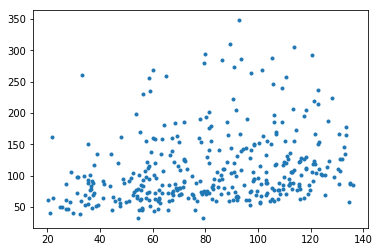

In [45]:
plot(pddataT['Dss'],(mesT[:,1]-mesT[:,3])/pddataT['A1'],'.')

# Analysis timed E/I

In [33]:
with open("../SpineModel/dis_ga_glu02x2.pickle","rb") as f:
    dis,mes1,mes01 = pickle.load(f)

with open("../SpineModel/dis_glu_ga02x2.pickle","rb") as f:
    dis,mes,mes0,times,times0 = pickle.load(f)

labels = ['Vh','A1','Ah','Dss','Rneck','Lhead']#,'meanDhead']
labels = ['A1','A2','Dss','Rneck','Lhead']#,'meanDhead']
datt = dis[labels[0]]
for l in labels[1:]:
    datt = column_stack((datt,dis[l]))

pddataT = pd.DataFrame(data=datt,columns=labels)

print("\nGABA-GLU----------------------------------------\n")
print('*'*10+'V in spine head'+10*'*')
print(LinReg_varexplain_B(pddataT,mes1[:,1]/mes01[:,1]))
print(LinReg_varexplain_F(pddataT,mes1[:,1]/mes01[:,1]))
print('*'*10+'V in dend shaft'+10*'*')
print(LinReg_varexplain_B(pddataT,mes1[:,2]/mes01[:,2]))
print(LinReg_varexplain_F(pddataT,mes1[:,2]/mes01[:,2]))
print('*'*10+'Calcium'+10*'*')
print(LinReg_varexplain_B(pddataT,mes1[:,4]/mes01[:,4]))
print(LinReg_varexplain_F(pddataT,mes1[:,4]/mes01[:,4]))

print("\nGLU-GABA----------------------------------------\n")
print('*'*10+'V in spine head'+10*'*')
print(LinReg_varexplain_B(pddataT,mes[:,1]/mes0[:,1]))
print(LinReg_varexplain_F(pddataT,mes[:,1]/mes0[:,1]))
print('*'*10+'V in dend shaft'+10*'*')
print(LinReg_varexplain_B(pddataT,mes[:,2]/mes0[:,2]))
print(LinReg_varexplain_F(pddataT,mes[:,2]/mes0[:,2]))
print('*'*10+'Calcium'+10*'*')
print(LinReg_varexplain_B(pddataT,mes[:,4]/mes0[:,4]))
print(LinReg_varexplain_F(pddataT,mes[:,4]/mes0[:,4]))
print('*'*10+'Time reduction'+10*'*')
print(LinReg_varexplain_B(pddataT,times/times0))
print(LinReg_varexplain_F(pddataT,times/times0))
print('*'*10+'Time'+10*'*')
print(LinReg_varexplain_B(pddataT,times0))
print(LinReg_varexplain_F(pddataT,times0))



GABA-GLU----------------------------------------

**********V in spine head**********
{'A2': 0.6797406861470394, 'Rneck': 0.17749488948776831, 'A1': 0.06277225683014932, 'Dss': 0.03163658515118568, 'Lhead': 0.0011040941412284802, 'variance': 0.002327178402794115}
{'A2': 0.6797406861470394, 'Rneck': 0.1707078273399114, 'A1': 0.04258750026962543, 'Dss': 0.03303945754080151, 'Lhead': 1.7126213283535918e-05}
**********V in dend shaft**********
{'A2': 0.6108709140454116, 'Rneck': 0.264102596199428, 'A1': 0.03171961538293053, 'Dss': 0.04677993453195515, 'Lhead': 0.002682090950735398, 'variance': 0.002991973838845423}
{'A2': 0.6108709140454116, 'Rneck': 0.25400382243197583, 'Dss': 0.030891295692436205, 'A1': 0.03623760861279968, 'Lhead': 0.0009951099032178279}
**********Calcium**********
{'A2': 0.5098224997154384, 'Dss': 0.2500969878892041, 'A1': 0.10749226777632684, 'Rneck': 0.06993539883271294, 'Lhead': 0.00017537949328590152, 'variance': 0.007984272634792965}
{'A2': 0.5098224997154384, 'D

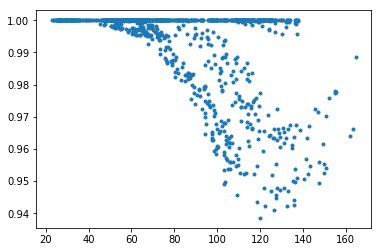

In [35]:
plot(pddataT['Dss'],mes[:,1]/mes0[:,1],'.')

In [46]:
plot(pddataT['Lhead'],pddataT['Dsp'])

KeyError: 'Dsp'

In [24]:
from sklearn.feature_selection import SelectKBest,VarianceThreshold,SelectFromModel, chi2, f_regression

from sklearn.linear_model import LassoCV


In [15]:
varthr = VarianceThreshold()
X = StandardScaler().fit_transform(datt)

varthr.fit_transform(datt)
yrt = mesT[:,3]

X_kbest=SelectKBest(score_func=f_regression,k=4).fit_transform(pddataT,yrt)


In [16]:
print(X_kbest)
pddataT.head()

[[2.37183829e-02 3.16088000e-02 1.38018256e+00 1.84601733e+02]
 [2.05218609e-01 3.10407000e-01 5.66545283e+00 4.74310921e+02]
 [3.57037012e-02 4.42527000e-02 1.52561796e+00 2.29820199e+02]
 ...
 [7.95727020e-02 9.63270000e-02 3.10240295e+00 3.14441268e+02]
 [2.51443079e-02 3.95413000e-02 1.32961270e+00 2.11225864e+02]
 [1.98156039e-02 3.74441000e-02 1.09136297e+00 1.92218969e+02]]


,Vh,A1,Ah,Dss,Rneck,Lhead,meanDhead
0,0.023718,0.031609,1.380183,89.548250,338.711631,0.713347,184.601733
1,0.205219,0.310407,5.665453,91.545924,35.839677,0.998565,474.310921
2,0.035704,0.044253,1.525618,91.752832,198.707384,0.722109,229.820199
3,0.058221,0.046848,2.241514,93.371587,60.946084,0.787828,292.001431
4,0.009354,0.012059,0.818723,92.727133,345.731900,0.751088,121.317864


In [17]:
regressor = LinearRegression()  
regressor.fit(pddataT, yrt)
y_pred = regressor.predict(datt)

sfm = SelectFromModel(regressor, threshold=1e-1)
sfm.fit(pddataT,yrt)
n_features = sfm.transform(pddataT).shape[1]

2


(0.0120591, 0.993682)

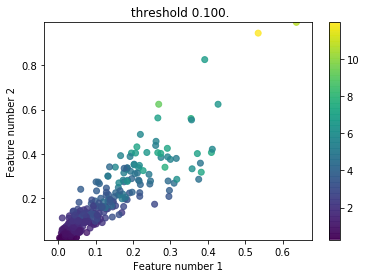

In [18]:
X_transform = sfm.transform(pddataT)
print(n_features)
plt.title(
    " "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
scatter(feature1, feature2, c = yrt,alpha=0.8)
colorbar()
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])


In [21]:
pddataT.corr()

NameError: name 'heatmap' is not defined

In [118]:
labels,varthr.variances_/varthr.variances_.sum()

(('Vh', 'A1', 'Ah', 'Dss', 'Rneck', 'Lhead', 'meanDhead'),
 array([4.91670737e-07, 1.02418117e-06, 2.41132114e-04, 4.50474138e-02,
        3.21126763e-01, 3.75174261e-06, 6.33579424e-01]))

In [68]:
i = 1
regressor.fit(datt[:,i:(i+1)], mesT[:,3])
y_pred0 = regressor.predict(datt[:,i:(i+1)])
var0 = ((mesT[:,3]-y_pred0)).var()
print(var0)
i = 3
regressor.fit(datt[:,i:(i+1)], mesT[:,3]-y_pred0)
y_pred1 = regressor.predict(datt[:,i:(i+1)])
var1 = ((mesT[:,3]-y_pred0-y_pred1)).var()
y_predt = y_pred0+y_pred1
for i in [0,2,4,5,6]:
    regressor.fit(datt[:,i:(i+1)], mesT[:,3]-y_predt)
    y_pred2 = regressor.predict(datt[:,i:(i+1)])
    var2 = ((mesT[:,3]-y_predt-y_pred2)).var()
    print(labels[i],var2,var(mesT[:,3]))

0.4074799523418079
Vh 0.2750157264237666 3.7354020984337533
Ah 0.26775476874295173 3.7354020984337533
Rneck 0.2442773651850881 3.7354020984337533
Lhead 0.28038418365570644 3.7354020984337533
meanDhead 0.2504158009079434 3.7354020984337533


In [9]:
# #############################################################################
# Generate random sample data
centers = [[1, 1,5,2], [-1, -1,3,4], [1, -1,2,4]]
X, _ = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

# Change X to real statistical data for spines
file = "spine_stats.dat"
X = load(file)


In [10]:
X = StandardScaler().fit_transform(X)
X.shape

(750, 4)

In [13]:
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 5
Estimated number of noise points: 578
Silhouette Coefficient: -0.410


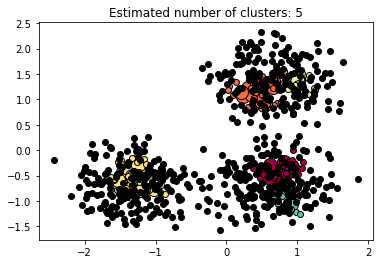

In [22]:
# #############################################################################
# Plot result
from matplotlib.pylab import cm
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [cm.Spectral(each) for each in linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

title('Estimated number of clusters: %d' % n_clusters_)
show()